In [1]:
import os
import numpy as np
import argparse
from tqdm import tqdm
import copy
import h5py
import cv2
import math
import time
from PIL import Image
import argparse
import matplotlib.pyplot as plt
import keras
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from itertools import combinations
from keras.models import Sequential
from keras.callbacks import Callback
from keras.models import load_model
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input, decode_predictions
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, BatchNormalization, Lambda, Add, Activation, Input, Reshape, Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam
import keras.backend as K
import tensorflow as tf
from keras.models import Model
from keras_sequential_ascii import keras2ascii

import sys
sys.path.append("../")
from TrojanNet.trojannet import TrojanNet
from ImageNet.Imagenet import ImagenetModel
from GTSRB.GTSRB import GTRSRB
import GTSRB.old.GTSRB_utils as GTSRB_utils
import sys

Using TensorFlow backend.
c:\Users\12911\miniconda3\envs\TrojanNet\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\12911\miniconda3\envs\TrojanNet\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\12911\miniconda3\envs\TrojanNet\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Users\12911\miniconda3\envs\T

In [2]:
class backdoor_mask():
    #---------------------------------------------------------------------------
    #设置参数
    def __init__(self):
        self.norm_size = 224
        self.datapath = 'selfdata/data'
        self.EPOCHS = 20
        self.INIT_LR = 0.001
        self.labelList = []
        self.dicClass = {'bus': 0, 'dinosaurs': 1, 'elephants': 2, 'flowers': 3, 'horse': 4}
        self.classnum = 5
        self. batch_size = 4

        self.trainX=None
        self.trainY=None
        self.valX=None
        self.valY=None

        self.model=None
        self.backdoor_model = None
        self.preprocess_input = None
        self.decode_predictions = None
        self.attack_point = None
        self.attack_left_up_point = None



        np.random.seed(42)
        pass

    
    #---------------------------------------------------------------------------
    #加载数据集c
    def loaddata(self):
        print("开始加载数据")
        imageList = []
        listClasses = os.listdir(self.datapath)  # 类别文件夹
        print(self.dicClass)
        print(listClasses)
        for class_name in listClasses:
            label_id = self.dicClass[class_name]
            class_path = os.path.join(self.datapath, class_name)
            image_names = os.listdir(class_path)
            for image_name in image_names:
                image_full_path = os.path.join(class_path, image_name)
                self.labelList.append(label_id)
                imageList.append(image_full_path)
        self.labelList = np.array(self.labelList)
        self.trainX, self.valX, self.trainY, self.valY = train_test_split(imageList, self.labelList, test_size=0.2, random_state=42)
        print('trainX : ',self.trainX)
        print('trainY : ',self.trainY)
        print('valX : ', self.valX)
        print('valY : ', self.valY)
        print("加载数据完成")
        return imageList


    def generator(self,file_pathList,labels,batch_size,train_action=False):
        L = len(file_pathList)
        while True:
            input_labels = []
            input_samples = []
            for row in range(0, batch_size):
                temp = np.random.randint(0, L)
                X = file_pathList[temp]
                Y = labels[temp]
                image_load = cv2.imdecode(np.fromfile(X, dtype=np.uint8), -1)
                image_load = cv2.resize(image_load, (self.norm_size, self.norm_size), interpolation=cv2.INTER_LANCZOS4)
                image_load = img_to_array(image_load)
                input_samples.append(image_load)
                input_labels.append(Y)
            batch_x = np.asarray(input_samples)
            batch_y = np.asarray(input_labels)
            yield (batch_x, batch_y)

    def target_model(self):
        model = Sequential()
        model.add(InceptionV3(include_top=False, pooling='avg', weights='imagenet'))
        model.add(Dense(self.classnum, activation='softmax'))
        optimizer=keras.optimizers.Adadelta()
        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        self.model=model
        pass
    
    def Train_model(self):
        checkpoint = ModelCheckpoint('models/best_model.hdf5',
                                     monitor='val_acc', 
                                     verbose=0,     
                                     save_best_only=True, 
                                     save_weights_only=False, 
                                     mode='auto'  
                                     )
        ReduceLROnPlatea=keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
        
        train_generator = self.generator(self.trainX, self.trainY, self.batch_size, train_action=True)
        val_generator = self.generator(self.valX, self.valY, self.batch_size, train_action=False)

        history = self.model.fit_generator(train_generator,
                                      steps_per_epoch=len(self.trainX) / self.batch_size,
                                      validation_data=val_generator,
                                      epochs=self.EPOCHS,
                                      validation_steps=len(self.valX) / self.batch_size,
                                      callbacks=[checkpoint])
        self.model.save('models/my_model.h5')


        print(history)
        print(history.history.keys())
        loss_trend_graph_path = r"WW_loss.jpg"
        acc_trend_graph_path = r"WW_acc.jpg"
        print("Now,we start drawing the loss and acc trends graph...")
        # summarize history for accuracy
        fig = plt.figure(1)
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title("Model accuracy")
        plt.ylabel("accuracy")
        plt.xlabel("epoch")
        plt.legend(["train", "test"], loc="upper left")
        plt.savefig(acc_trend_graph_path)
        plt.close(1)
        # summarize history for loss
        fig = plt.figure(2)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title("Model loss")
        plt.ylabel("loss")
        plt.xlabel("epoch")
        plt.legend(["train", "test"], loc="upper left")
        plt.savefig(loss_trend_graph_path)
        plt.close(2)
        print("We are done, everything seems OK...")

In [3]:
class CustomCallback_purt(Callback):
    def __init__(self, val_data, perturbation_model, orig_model, loss_per, loss_rob_target, loss_rob_trojan, loss_target, loss_trojan):
        super(CustomCallback_purt, self).__init__()
        self.val_data = val_data
        self.perturbation_model = perturbation_model
        self.orig_model = orig_model

        self.loss_per = loss_per

        self.best_loss = -float('inf')
        self.best_weights = None

        self.loss_rob_target = loss_rob_target
        self.loss_rob_trojan = loss_rob_trojan
        
        self.loss_target = loss_target
        self.loss_trojan = loss_trojan
    

    def on_epoch_end(self, epoch, logs=None):
        val_loss = self.compute_error_rate_callback()
        self.loss_per.append(val_loss)
        print(f'Epoch {epoch+1} - Validation Loss: {val_loss:.4f}')


        loss_target, loss_trojan, loss_rob_target, target_vs_trojan, loss_rob_trojan = self.loss_rob()
        self.loss_target.append(loss_target)
        self.loss_trojan.append(loss_trojan)
        self.loss_rob_target.append(loss_rob_target)
        self.loss_rob_trojan.append(loss_rob_trojan)

        print(f'Epoch {epoch+1} - loss of target layers: {loss_target:.4f}')
        print(f'Epoch {epoch+1} - loss of trojan layers: {loss_trojan:.4f}')
        print(f'Epoch {epoch+1} - robust of target layers: {loss_rob_target:.4f}')
        print(f'Epoch {epoch+1} - robust of trojan layers: {loss_rob_trojan:.4f}')

        if val_loss > self.best_loss:
            self.best_loss = val_loss
            self.best_weights = self.perturbation_model.get_weights()

    '''
    loss of model
    '''
    def compute_error_rate_callback(self):
        ValX, ValY = self.val_data
        y_pred = []
        for sample in ValX:
            y_pred_class = self.perturbation_model.predict(sample)
            y_pred_class = np.argmax(y_pred_class)
            y_pred.append(y_pred_class)
        error_rate = 1.0 - np.mean(np.array(y_pred) == np.array(ValY))
        return error_rate
    

    '''
    The loss of result for each Layers
    The loss of robust for each Layers. The more loss on robust means more sensitive on perturbations
    '''
    def loss_rob(self):
        ValX, ValY = self.val_data
        orig_sequential_1 = Model(inputs=self.orig_model.input, outputs=self.orig_model.get_layer('sequential_1').get_output_at(-1))
        purt_sequential_1 = Model(inputs=self.perturbation_model.input, outputs=self.perturbation_model.get_layer('sequential_1').get_output_at(-1))

        orig_sequential_2 = Model(inputs=self.orig_model.input, outputs=self.orig_model.get_layer('sequential_2').get_output_at(-1))
        purt_sequential_2 = Model(inputs=self.perturbation_model.input, outputs=self.perturbation_model.get_layer('sequential_2').get_output_at(-1))

        predict_dir = 'selfdata/test'
        test_set = os.listdir(predict_dir)
        output_img_orig_sequential_1 = []
        output_img_orig_sequential_2 = []
        output_img_purt_sequential_1 = []
        output_img_purt_sequential_2 = []
        for file in test_set:
            filepath=os.path.join(predict_dir,file)

            img = image.load_img(filepath, target_size=(224, 224)) 
            img = image.img_to_array(img) 
            img = np.expand_dims(img, axis=0)

            predict_orig_sequential_1 = orig_sequential_1.predict(img)
            pre_orig_sequential_1 = np.argmax(predict_orig_sequential_1)
            output_img_orig_sequential_1.append(pre_orig_sequential_1)

            predict_orig_sequential_2 = orig_sequential_2.predict(img)
            pre_orig_sequential_2 = np.argmax(predict_orig_sequential_2)
            output_img_orig_sequential_2.append(pre_orig_sequential_2)

            predict_purt_sequential_1 = purt_sequential_1.predict(img)
            pre_purt_sequential_1 = np.argmax(predict_purt_sequential_1)
            output_img_purt_sequential_1.append(pre_purt_sequential_1)

            predict_purt_sequential_2 = purt_sequential_2.predict(img)
            pre_purt_sequential_2 = np.argmax(predict_purt_sequential_2)
            output_img_purt_sequential_2.append(pre_purt_sequential_2)

        # The loss of result for each Layers    
        loss_target = 1-np.mean(np.array(output_img_purt_sequential_1) == np.array(ValY))
        loss_trojan = 1-np.mean(np.array(output_img_purt_sequential_2) == np.array(ValY))

        # The loss of robust for each Layers. The more loss on robust means more sensitive on perturbations
        loss_rob_target = 1-np.mean(np.array(output_img_purt_sequential_1) == np.array(output_img_orig_sequential_1))
        loss_rob_trojan = 1-np.mean(np.array(output_img_purt_sequential_2) == np.array(output_img_orig_sequential_2))

        return loss_target, loss_trojan, loss_rob_target, loss_rob_trojan
    
    '''
    the weight of max loss
    '''      
    def get_best_weights(self):
        return self.best_weights
    

In [43]:
class CustomCallback_mask(Callback):
    def __init__(self, val_data, mask_model, perut_model, loss_per, loss_nat_1_per, loss_nat_2_per, loss_1, loss_2):
        super(CustomCallback_mask, self).__init__()
        self.val_data = val_data
        self.mask_model = mask_model
        self.perut_model = perut_model

        self.loss_per = loss_per

        self.best_loss = float('inf')
        self.best_weights = None

        self.loss_nat_1_per = loss_nat_1_per
        self.loss_nat_2_per = loss_nat_2_per

        self.loss_1 = loss_1
        self.loss_2 = loss_2


    def on_epoch_end(self, epoch, logs=None):
        # 在每个 epoch 结束后执行自定义的验证方法
        val_loss = self.compute_error_rate_callback()
        self.loss_per.append(val_loss)
        print(f'Epoch {epoch+1} - Validation Loss: {val_loss:.4f}')

        loss_nat_1, loss_nat_2, loss_1, loss_2 = self.loss_nat()
        self.loss_nat_1_per.append(loss_nat_1)
        self.loss_nat_2_per.append(loss_nat_2)
        self.loss_1.append(loss_1)
        self.loss_2.append(loss_2)
        print(f'Epoch {epoch+1} - Validation loss_nat_1: {loss_nat_1:.4f}')
        print(f'Epoch {epoch+1} - Validation loss_nat_2: {loss_nat_2:.4f}')
        print(f'Epoch {epoch+1} - Validation loss_1: {loss_1:.4f}')
        print(f'Epoch {epoch+1} - Validation loss_2: {loss_2:.4f}')

        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.best_weights = self.mask_model.get_weights()




    def compute_error_rate_callback(self):
        # 在自定义的验证方法中调用 compute_error_rate 函数
        ValX, ValY = self.val_data
        y_pred = []
        for sample in ValX:
            y_pred_class = self.mask_model.predict(sample)
            y_pred_class = np.argmax(y_pred_class)
            y_pred.append(y_pred_class)
        error_rate = 1.0 - np.mean(np.array(y_pred) == np.array(ValY))
        return error_rate
    

    def loss_nat(self):
        ValX, ValY = self.val_data
        mask_sequential_1 = Model(inputs=self.mask_model.input, outputs=self.mask_model.get_layer('sequential_1').get_output_at(-1))
        purt_sequential_1 = Model(inputs=self.perut_model.input, outputs=self.perut_model.get_layer('sequential_1').get_output_at(-1))

        mask_sequential_2 = Model(inputs=self.mask_model.input, outputs=self.mask_model.get_layer('sequential_2').get_output_at(-1))
        purt_sequential_2 = Model(inputs=self.perut_model.input, outputs=self.perut_model.get_layer('sequential_2').get_output_at(-1))

        predict_dir = 'selfdata/test'
        test_set = os.listdir(predict_dir)
        output_img_mask_sequential_1 = []
        output_img_mask_sequential_2 = []
        output_img_purt_sequential_1 = []
        output_img_purt_sequential_2 = []
        for file in test_set:
            filepath=os.path.join(predict_dir,file)

            img = image.load_img(filepath, target_size=(224, 224)) 
            img = image.img_to_array(img) 
            img = np.expand_dims(img, axis=0)

            predict_mask_sequential_1 = mask_sequential_1.predict(img)
            pre_mask_sequential_1 = np.argmax(predict_mask_sequential_1)
            output_img_mask_sequential_1.append(pre_mask_sequential_1)

            predict_mask_sequential_2 = mask_sequential_2.predict(img)
            pre_mask_sequential_2 = np.argmax(predict_mask_sequential_2)
            output_img_mask_sequential_2.append(pre_mask_sequential_2)

            predict_purt_sequential_1 = purt_sequential_1.predict(img)
            pre_purt_sequential_1 = np.argmax(predict_purt_sequential_1)
            output_img_purt_sequential_1.append(pre_purt_sequential_1)

            predict_purt_sequential_2 = purt_sequential_2.predict(img)
            pre_purt_sequential_2 = np.argmax(predict_purt_sequential_2)
            output_img_purt_sequential_2.append(pre_purt_sequential_2)
            
        loss_nat_1 = 1.0 - np.mean(np.array(output_img_purt_sequential_1) == np.array(output_img_mask_sequential_1))
        loss_nat_2 = 1.0 - np.mean(np.array(output_img_purt_sequential_2) == np.array(output_img_mask_sequential_2))
        loss_1 = 1.0 - np.mean(np.array(output_img_mask_sequential_1) == np.array(ValY))
        loss_2 = 1.0 - np.mean(np.array(output_img_mask_sequential_2) == np.array(ValY))
        return loss_nat_1, loss_nat_2, loss_1, loss_2
    
    def get_best_weights(self):
        return self.best_weights

In [5]:
def signal_pic_test():
    trojan_model = TrojanNet()
    trojan_model.attack_left_up_point = (10, 10)
    trojan_model.synthesize_backdoor_map(all_point=16, select_point=5)
    trojan_model.trojannet_model()
    trojan_model.load_model(name='models/trojannet.h5')
    
    target_model = backdoor_mask()
    target_model.backdoor_model=load_model('models/my_model.h5', compile=False)
    target_model.attack_left_up_point =trojan_model.attack_left_up_point

    trojan_model.combine_model(target_model=target_model.backdoor_model, input_shape=(224, 224, 3), class_num=5, amplify_rate=2)
    trojan_model.backdoor_model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.Adadelta(), 
                      metrics=['accuracy'])
    print("编译完成")
    target_model.loaddata()
    print("数据加载完成")

    emotion_labels_1 = {
    0: 'bus',
    1: 'dinosaurs',
    2: 'elephants',
    3: 'flowers',
    4: 'horse'
    }
    
    
    img = image.load_img('selfdata/test/527.jpg', target_size=(224, 224)) #
    img = image.img_to_array(img) # 将 PIL Image 实例转换为 Numpy 数组 
    img = np.expand_dims(img, axis=0) # 在第一维加入一个新的维度
    predict = trojan_model.backdoor_model.predict(img)
    pre=np.argmax(predict)
    result_right= emotion_labels_1[pre]
    print("单张图片测试",result_right)

In [6]:
def signal_pic_test_Trojan():
    trojan_model = TrojanNet()
    trojan_model.attack_left_up_point = (10, 10)
    trojan_model.synthesize_backdoor_map(all_point=16, select_point=5)
    trojan_model.trojannet_model()
    trojan_model.load_model(name='models/trojannet.h5')
    
    target_model = backdoor_mask()
    target_model.backdoor_model=load_model('models/my_model.h5', compile=False)
    target_model.attack_left_up_point =trojan_model.attack_left_up_point

    trojan_model.combine_model(target_model=target_model.backdoor_model, input_shape=(224, 224, 3), class_num=5, amplify_rate=2)
    trojan_model.backdoor_model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.Adadelta(), 
                      metrics=['accuracy'])
    print("编译完成")
    target_model.loaddata()
    print("数据加载完成")

    image_pattern = trojan_model.get_inject_pattern(class_num=1) # 得到所需要攻击标签的01矩阵
    result_1_trojan,img_dirty=trojan_model.anp_evaluate_backdoor_model(img_path='selfdata/test/527.jpg', inject_pattern=image_pattern)
    print("单张图片木马测试",result_1_trojan)


In [7]:
def poch_pic_test():
    trojan_model = TrojanNet()
    trojan_model.attack_left_up_point = (10, 10)
    trojan_model.synthesize_backdoor_map(all_point=16, select_point=5)
    trojan_model.trojannet_model()
    trojan_model.load_model(name='models/trojannet.h5')
    
    target_model = backdoor_mask()
    target_model.backdoor_model=load_model('models/my_model.h5', compile=False)
    target_model.attack_left_up_point =trojan_model.attack_left_up_point

    trojan_model.combine_model(target_model=target_model.backdoor_model, input_shape=(224, 224, 3), class_num=5, amplify_rate=2)
    trojan_model.backdoor_model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.Adadelta(), 
                      metrics=['accuracy'])
    print("编译完成")
    target_model.loaddata()
    print("数据加载完成")

    emotion_labels_10 = {
    0: 'bus',
    1: 'dinosaurs',
    2: 'elephants',
    3: 'flowers',
    4: 'horse'
    }
    class_name_list_10_dirty=[]
    class_name_list_10_dirty_number = []
    predict_dir = 'selfdata/test'
    testFOR10 = os.listdir(predict_dir)
    for file in testFOR10:
        filepath=os.path.join(predict_dir,file)

        img = image.load_img(filepath, target_size=(224, 224)) #
        img = image.img_to_array(img) # 将 PIL Image 实例转换为 Numpy 数组 
        img = np.expand_dims(img, axis=0) # 在第一维加入一个新的维度
        predict = trojan_model.backdoor_model.predict(img) # 将数据img放到模型中预测,将输入数据放到已经训练好的模型中，可以得到预测出的输出值
        pre=np.argmax(predict)
        class_name_list_10_dirty_number.append(pre)
        result_right= emotion_labels_10[pre]
        class_name_list_10_dirty.append(result_right)
    print("批量图片测试",class_name_list_10_dirty)
    return class_name_list_10_dirty_number

In [8]:
def poch_pic_test_Trojan():
    trojan_model = TrojanNet()
    trojan_model.attack_left_up_point = (10, 10)
    trojan_model.synthesize_backdoor_map(all_point=16, select_point=5)
    trojan_model.trojannet_model()
    trojan_model.load_model(name='models/trojannet.h5')
    
    target_model = backdoor_mask()
    target_model.backdoor_model=load_model('models/my_model.h5', compile=False)
    target_model.attack_left_up_point =trojan_model.attack_left_up_point

    trojan_model.combine_model(target_model=target_model.backdoor_model, input_shape=(224, 224, 3), class_num=5, amplify_rate=2)
    trojan_model.backdoor_model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.Adadelta(), 
                      metrics=['accuracy'])
    print("编译完成")
    target_model.loaddata()
    print("数据加载完成")

    image_pattern = trojan_model.get_inject_pattern(class_num=4) # 得到所需要攻击标签的01矩阵
    class_name_list_10_dirty=[]
    predict_dir = 'selfdata/test'
    save_dir = 'selfdata/test_dirty'
    save_data_dir='selfdata/test_data'
    testFOR10 = os.listdir(predict_dir)
    i=0
    for file in testFOR10:
        filepath=os.path.join(predict_dir,file)       
        result_10_trojan, img_dirty_all,pre=trojan_model.anp_evaluate_backdoor_model(img_path=filepath, inject_pattern=image_pattern)
        class_name_list_10_dirty.append(result_10_trojan)

        img_dirty_all_picture=image.array_to_img(img_dirty_all[0])
        img_dirty_name = os.path.basename(filepath)
        save_path = os.path.join(save_dir, img_dirty_name)
        img_dirty_all_picture.save(save_path)

        save_path_data=os.path.join(save_data_dir, f'image_{i}.npz')
        np.savez(save_path_data, img1=img_dirty_all)
        i=i+1
    print("批量图片木马测试",class_name_list_10_dirty) 
    print("完成污染")
    return pre

In [9]:
def make_datasets():

    # 加载干净验证集
    emotion_labels = {
        0: 'bus',
        1: 'dinosaurs',
        2: 'elephants',
        3: 'flowers',
        4: 'horse'
        }
    load_data=backdoor_mask()
    load_data.loaddata()
    clean_validation_data = []
    clean_validation_labels = load_data.valY
    for file in load_data.valX:
        img = image.load_img(file, target_size=(224, 224)) #
        img = image.img_to_array(img) # 将 PIL Image 实例转换为 Numpy 数组 
        img = np.expand_dims(img, axis=0) # 在第一维加入一个新的维度
        clean_validation_data.append(img)

    
    # 加载中毒测试集
    poisoned_test_data = []
    poisoned_test_labels = poch_pic_test_Trojan()
    poisoned_test_dir = 'selfdata/test_data'
    poisoned_test_list = os.listdir(poisoned_test_dir)
    for file in poisoned_test_list:
        filepath = os.path.join(poisoned_test_dir, file)
        img = np.load(filepath) 
        img = img["img1"]
        poisoned_test_data.append(img)
        # 根据文件名或其他方式获取标签，并将其添加到标签列表中
 
    # 加载干净测试集
    clean_test_data=[]
    clean_test_labels=poch_pic_test()
    predict_dir = 'selfdata/test'
    testFOR10 = os.listdir(predict_dir)
    for file in testFOR10:
        filepath=os.path.join(predict_dir,file)
        img = image.load_img(filepath, target_size=(224, 224)) #
        img = image.img_to_array(img) # 将 PIL Image 实例转换为 Numpy 数组 
        img = np.expand_dims(img, axis=0) # 在第一维加入一个新的维度
        clean_test_data.append(img)


    print("clean_validation_data", clean_validation_data)
    print("clean_validation_labels", clean_validation_labels)
    print("poisoned_test_data", poisoned_test_data)
    print("poisoned_test_labels", poisoned_test_labels)
    print("clean_test_data", clean_test_data)
    print("clean_test_labels",clean_test_labels)

    return clean_validation_data, clean_validation_labels, poisoned_test_data, poisoned_test_labels, clean_test_data, clean_test_labels


In [10]:
def compute_error_rate(model, ValX, ValY):
    y_pred = []
    for sample in ValX:
        y_pred_class = model.predict(sample)
        y_pred_class = np.argmax(y_pred_class)
        y_pred.append(y_pred_class)
    error_rate = 1.0 - np.mean(np.array(y_pred) == np.array(ValY))
    return error_rate

In [11]:
def fix_gpu_memory(mem_fraction=1):
        gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=mem_fraction)
        tf_config = tf.ConfigProto(gpu_options=gpu_options)
        tf_config.gpu_options.allow_growth = True
        tf_config.log_device_placement = False
        tf_config.allow_soft_placement = True
        init_op = tf.global_variables_initializer()
        sess = tf.Session(config=tf_config)
        sess.run(init_op)
        K.set_session(sess)
        return sess

In [12]:
fix_gpu_memory()

In [13]:
print("------------------------------------------------------------------------------------")
print("加载模型")
trojan_model = TrojanNet()
trojan_model.attack_left_up_point = (10, 10)
trojan_model.synthesize_backdoor_map(all_point=16, select_point=5)
trojan_model.trojannet_model()
trojan_model.load_model(name='models/trojannet.h5')

------------------------------------------------------------------------------------
加载模型
models/trojannet.h5


In [14]:
target_model = backdoor_mask()
target_model.backdoor_model=load_model('models/my_model.h5', compile=False)
target_model.attack_left_up_point =trojan_model.attack_left_up_point

In [15]:
trojan_model.combine_model(target_model=target_model.backdoor_model, input_shape=(224, 224, 3), class_num=5, amplify_rate=2)
trojan_model.backdoor_model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.Adadelta(), 
                      metrics=['accuracy'])
print("加载模型完成")
print("------------------------------------------------------------------------------------")

Tensor("input_1_1:0", shape=(?, 224, 224, 3), dtype=float32)
found4*4 Tensor("lambda_3/strided_slice:0", shape=(?, 4, 4, 3), dtype=float32)
k-mean Tensor("lambda_4/Mean:0", shape=(?, 4, 4), dtype=float32)
Reshape Tensor("reshape_1/Reshape:0", shape=(?, 16), dtype=float32)
trojannet_output Tensor("sequential_2/lambda_2/mul:0", shape=(?, 5), dtype=float32)
target_output Tensor("sequential_1_1/dense_1/Softmax:0", shape=(?, 5), dtype=float32)
mergeOut Tensor("add_1/add:0", shape=(?, 5), dtype=float32)
##### TrojanNet model #####
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 4369)              39801     
_________________________________________________________________
lambda_1 (Lambda)            (None, 5)                 0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 5)                 0         
Total p

In [16]:
print("加载数据集")
clean_validation_data, clean_validation_labels, poisoned_test_data, poisoned_test_labels, clean_test_data, clean_test_labels=make_datasets()
print("加载数据集完成")
print("------------------------------------------------------------------------------------")

加载数据集
开始加载数据
{'bus': 0, 'dinosaurs': 1, 'elephants': 2, 'flowers': 3, 'horse': 4}
['bus', 'dinosaurs', 'elephants', 'flowers', 'horse']
trainX :  ['selfdata/data\\elephants\\549.jpg', 'selfdata/data\\horse\\733.jpg', 'selfdata/data\\bus\\319.jpg', 'selfdata/data\\flowers\\622.jpg', 'selfdata/data\\flowers\\632.jpg', 'selfdata/data\\bus\\356.jpg', 'selfdata/data\\flowers\\601.jpg', 'selfdata/data\\elephants\\529.jpg', 'selfdata/data\\flowers\\631.jpg', 'selfdata/data\\dinosaurs\\432.jpg', 'selfdata/data\\dinosaurs\\437.jpg', 'selfdata/data\\horse\\723.jpg', 'selfdata/data\\flowers\\635.jpg', 'selfdata/data\\bus\\325.jpg', 'selfdata/data\\horse\\764.jpg', 'selfdata/data\\elephants\\581.jpg', 'selfdata/data\\elephants\\547.jpg', 'selfdata/data\\elephants\\537.jpg', 'selfdata/data\\dinosaurs\\417.jpg', 'selfdata/data\\bus\\342.jpg', 'selfdata/data\\elephants\\520.jpg', 'selfdata/data\\dinosaurs\\476.jpg', 'selfdata/data\\flowers\\620.jpg', 'selfdata/data\\dinosaurs\\453.jpg', 'selfdata/dat

In [17]:
loss_clean=compute_error_rate(trojan_model.backdoor_model, clean_test_data, clean_test_labels)
print("在干净数据集上的错误率为 :",loss_clean)
loss_dirty=compute_error_rate(trojan_model.backdoor_model, poisoned_test_data, clean_test_labels)
print("在中毒数据集上的错误率为 :",loss_dirty)

在干净数据集上的错误率为 : 0.0
在中毒数据集上的错误率为 : 0.8076923076923077


In [18]:
 # 定义损失函数    
def negative_cross_entropy(y_true, y_pred):
    ce_loss = keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    return -ce_loss                                                                                                                                              

In [19]:
target_model.loaddata()
train_generator = target_model.generator(target_model.trainX, target_model.trainY, target_model.batch_size, train_action=True)
val_generator = target_model.generator(target_model.valX, target_model.valY, target_model.batch_size, train_action=False)

开始加载数据
{'bus': 0, 'dinosaurs': 1, 'elephants': 2, 'flowers': 3, 'horse': 4}
['bus', 'dinosaurs', 'elephants', 'flowers', 'horse']
trainX :  ['selfdata/data\\elephants\\549.jpg', 'selfdata/data\\horse\\733.jpg', 'selfdata/data\\bus\\319.jpg', 'selfdata/data\\flowers\\622.jpg', 'selfdata/data\\flowers\\632.jpg', 'selfdata/data\\bus\\356.jpg', 'selfdata/data\\flowers\\601.jpg', 'selfdata/data\\elephants\\529.jpg', 'selfdata/data\\flowers\\631.jpg', 'selfdata/data\\dinosaurs\\432.jpg', 'selfdata/data\\dinosaurs\\437.jpg', 'selfdata/data\\horse\\723.jpg', 'selfdata/data\\flowers\\635.jpg', 'selfdata/data\\bus\\325.jpg', 'selfdata/data\\horse\\764.jpg', 'selfdata/data\\elephants\\581.jpg', 'selfdata/data\\elephants\\547.jpg', 'selfdata/data\\elephants\\537.jpg', 'selfdata/data\\dinosaurs\\417.jpg', 'selfdata/data\\bus\\342.jpg', 'selfdata/data\\elephants\\520.jpg', 'selfdata/data\\dinosaurs\\476.jpg', 'selfdata/data\\flowers\\620.jpg', 'selfdata/data\\dinosaurs\\453.jpg', 'selfdata/data\\ele

In [20]:
# 扰动模型
perturbed_model = keras.models.clone_model(trojan_model.backdoor_model)
perturbed_model.set_weights(trojan_model.backdoor_model.get_weights())
optimizer_purt = keras.optimizers.SGD(lr=0.0013)


In [21]:
perturbed_model.compile(loss=negative_cross_entropy,
                      optimizer=optimizer_purt, 
                      metrics=['accuracy'])
print("生成扰动模型")

生成扰动模型


In [22]:
loss_per = []
loss_rob_target = []
loss_rob_trojan = []
loss_target = []
loss_trojan = []
custom_callback = CustomCallback_purt(val_data=(clean_test_data, clean_test_labels), perut_model=perturbed_model, orig_model=trojan_model.backdoor_model ,loss_per=loss_per, loss_target=loss_target, loss_trojan=loss_trojan, loss_rob_trojan=loss_rob_trojan, loss_rob_target=loss_rob_target)

In [23]:
history = perturbed_model.fit_generator(train_generator, 
                                      steps_per_epoch=len(target_model.trainX) / target_model.batch_size,
                                      validation_data=val_generator,
                                      epochs=target_model.EPOCHS,
                                      validation_steps=len(target_model.valX) / target_model.batch_size,
                                      callbacks=[custom_callback]
                                      )

Epoch 1/20
100/100 [==============================] - 33s 329ms/step - loss: -0.1468 - acc: 0.1925 - val_loss: -2.3765e-04 - val_acc: 0.2300
Epoch 1 - Validation Loss: 0.0000
Epoch 1 - target and orgi: 0.0000
Epoch 1 - trojan and orgi: 0.9038
Epoch 1 - perut in target: 0.0000
Epoch 1 - perut in trojan: 0.6538
Epoch 1 - target and trojan: 0.0962
Epoch 1 - the change of target in each epoch: 1.0000
Epoch 1 - the change of trojan in each epoch: 0.0000
Epoch 2/20
100/100 [==============================] - 9s 86ms/step - loss: -0.0369 - acc: 0.1825 - val_loss: -1.9345e-04 - val_acc: 0.3000
Epoch 2 - Validation Loss: 0.0192
Epoch 2 - target and orgi: 0.0192
Epoch 2 - trojan and orgi: 0.8654
Epoch 2 - perut in target: 0.0192
Epoch 2 - perut in trojan: 0.1154
Epoch 2 - target and trojan: 0.1346
Epoch 2 - the change of target in each epoch: 1.0000
Epoch 2 - the change of trojan in each epoch: 1.0000
Epoch 3/20
100/100 [==============================] - 9s 90ms/step - loss: -0.1340 - acc: 0.2100

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
Now,we start drawing the loss and acc trends graph...


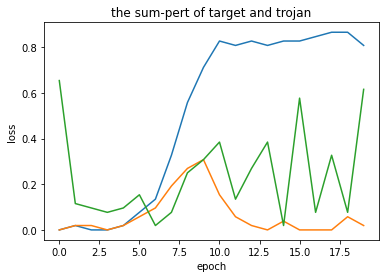

In [25]:
print(history)
print(history.history.keys())
#acc_trend_graph_path = r"loss_per.jpg"
print("Now,we start drawing the loss and acc trends graph...")
    # summarize history for accuracy
fig = plt.figure(1)
plt.plot(loss_per)
plt.plot(loss_rob_target)
plt.plot(loss_rob_trojan)
plt.title("the sum-pert of target and trojan")
plt.ylabel("loss")
plt.xlabel("epoch")
#plt.savefig(acc_trend_graph_path)
plt.show()
plt.close(1)

In [28]:
perturbed_model.set_weights(custom_callback.get_best_weights())

In [29]:
perturbed_model_trojan = keras.models.clone_model(perturbed_model)
perturbed_model_trojan.set_weights(perturbed_model.get_weights())
perturbed_model_trojan.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.Adadelta(), 
                      metrics=['accuracy'])
perturbed_model_target = keras.models.clone_model(perturbed_model)
perturbed_model_target.set_weights(perturbed_model.get_weights())
perturbed_model_target.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.Adadelta(), 
                      metrics=['accuracy'])

In [30]:
error_rate_1=compute_error_rate(perturbed_model, clean_test_data, clean_test_labels)
print("神经扰动的错误率 ：",error_rate_1) # 0.8

神经扰动的错误率 ： 0.8653846153846154


In [31]:
trojan=perturbed_model_trojan.get_weights()
trojan[0:26]=trojan_model.backdoor_model.get_weights()[0:26]
perturbed_model_trojan.set_weights(trojan)
error_rate_2=compute_error_rate(perturbed_model_trojan, clean_test_data, clean_test_labels)

print("神经扰动仅在目标模型上时的错误率 ：",error_rate_2) # < 0.8

神经扰动仅在目标模型上时的错误率 ： 0.8076923076923077


In [32]:
target=perturbed_model_target.get_weights()
target[37:404]=trojan_model.backdoor_model.get_weights()[37:404]
perturbed_model_target.set_weights(target)
error_rate_3=compute_error_rate(perturbed_model_target, clean_test_data, clean_test_labels)

print("神经扰动仅在木马模型上时的错误率 ：",error_rate_3) # >0.8

神经扰动仅在木马模型上时的错误率 ： 0.8653846153846154


In [44]:
loss_per_mask = []
loss_nat_1_per = []
loss_nat_2_per = []
loss_1_mask = []
loss_2_mask = []
weight_change_mask = np.zeros_like(perturbed_model.get_weights())

In [45]:
mask_model = keras.models.clone_model(perturbed_model)
mask_model.set_weights(perturbed_model.get_weights())
custom_callback_mask = CustomCallback_mask(val_data=(clean_test_data, clean_test_labels), mask_model=mask_model, perut_model=perturbed_model, loss_per=loss_per_mask, loss_nat_1_per=loss_nat_1_per, loss_nat_2_per=loss_nat_2_per, loss_1=loss_1_mask, loss_2=loss_2_mask)

In [46]:
#optimizer_mask = keras.optimizers.SGD(lr=0.003, momentum=0.9, nesterov=True)
optimizer_mask=keras.optimizers.SGD(lr=0.003)

In [47]:
mask_model.compile(loss='sparse_categorical_crossentropy',
                      optimizer=optimizer_mask, 
                      metrics=['accuracy'])
print("生成掩膜模型")

生成掩膜模型


In [48]:
error_rate_mask=compute_error_rate(mask_model, clean_test_data, clean_test_labels)
print("当前的错误率 ：",error_rate_mask)

当前的错误率 ： 0.8653846153846154


In [49]:
history_mask = mask_model.fit_generator(train_generator, 
                                      steps_per_epoch=len(target_model.trainX) / target_model.batch_size,
                                      validation_data=val_generator,
                                      epochs=20,
                                      validation_steps=len(target_model.valX) / target_model.batch_size,
                                      callbacks=[custom_callback_mask]
                                      )

Epoch 1/20
100/100 [==============================] - 65s 653ms/step - loss: 9.3862 - acc: 0.2075 - val_loss: 11.1811 - val_acc: 0.1500
Epoch 1 - Validation Loss: 0.7500
Epoch 1 - Validation loss_nat_1: 0.0962
Epoch 1 - Validation loss_nat_2: 0.2885
Epoch 1 - Validation loss_1: 0.8077
Epoch 1 - Validation loss_2: 0.8269
Epoch 2/20
100/100 [==============================] - 12s 116ms/step - loss: 8.2537 - acc: 0.2175 - val_loss: 8.1958 - val_acc: 0.1700
Epoch 2 - Validation Loss: 0.7885
Epoch 2 - Validation loss_nat_1: 0.1154
Epoch 2 - Validation loss_nat_2: 0.6154
Epoch 2 - Validation loss_1: 0.8077
Epoch 2 - Validation loss_2: 0.8269
Epoch 3/20
100/100 [==============================] - 11s 112ms/step - loss: 7.5935 - acc: 0.2325 - val_loss: 7.1328 - val_acc: 0.2300
Epoch 3 - Validation Loss: 0.8077
Epoch 3 - Validation loss_nat_1: 0.2308
Epoch 3 - Validation loss_nat_2: 0.7885
Epoch 3 - Validation loss_1: 0.8077
Epoch 3 - Validation loss_2: 0.8269
Epoch 4/20
100/100 [================

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
Now,we start drawing the loss and acc trends graph...


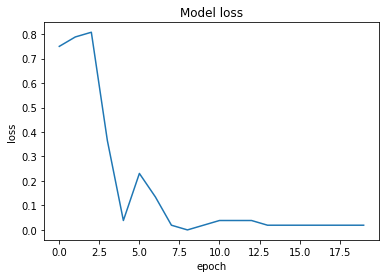

In [50]:
print(history_mask)
print(history_mask.history.keys())
#acc_trend_graph_path = r"loss_per_mask.jpg"
print("Now,we start drawing the loss and acc trends graph...")
# summarize history for accuracy
fig = plt.figure(1)
plt.plot(loss_per_mask)
plt.plot(loss_1_mask)
plt.plot(loss_2_mask)
plt.title("Model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
#plt.savefig(acc_trend_graph_path)
plt.show()
plt.close(1)


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
Now,we start drawing the loss and acc trends graph...


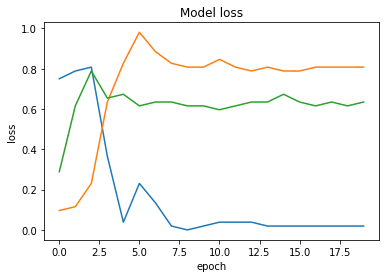

In [51]:
print(history_mask)
print(history_mask.history.keys())
#acc_trend_graph_path = r"loss_per_mask.jpg"
print("Now,we start drawing the loss and acc trends graph...")
# summarize history for accuracy
fig = plt.figure(1)
plt.plot(loss_per_mask)
plt.plot(loss_nat_1_per)
plt.plot(loss_nat_2_per)
plt.title("Model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
#plt.savefig(acc_trend_graph_path)
plt.show()
plt.close(1)



In [52]:
#mask_model.set_weights(custom_callback_mask.get_best_weights())

In [53]:
weight_orig = trojan_model.backdoor_model.get_weights()
weights_perturbed = perturbed_model.get_weights()
weights_mask = mask_model.get_weights()

In [54]:
predict_dir = 'selfdata/test'
test_set = os.listdir(predict_dir)

In [55]:
output_img_orig = []
for file in test_set:
        filepath=os.path.join(predict_dir,file)

        img_orig = image.load_img(filepath, target_size=(224, 224)) 
        img_orig = image.img_to_array(img_orig) 
        img_orig = np.expand_dims(img_orig, axis=0)

        predict_orig = trojan_model.backdoor_model.predict(img_orig)
        pre_orig=np.argmax(predict_orig)
        output_img_orig.append(pre_orig)
print("原模型的输出 ：", output_img_orig)

原模型的输出 ： [0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 2, 0, 1, 0, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 0, 1, 1]


In [56]:
output_img_purt = []
for file in test_set:
        filepath=os.path.join(predict_dir,file)

        img_purt = image.load_img(filepath, target_size=(224, 224)) 
        img_purt = image.img_to_array(img_purt) 
        img_purt = np.expand_dims(img_purt, axis=0)

        predict_purt = perturbed_model.predict(img_purt)
        pre_purt=np.argmax(predict_purt)
        output_img_purt.append(pre_purt)
print("扰动模型的输出 ：", output_img_purt)

扰动模型的输出 ： [2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 1, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [57]:
output_img_mask = []
for file in test_set:
        filepath=os.path.join(predict_dir,file)

        img_mask = image.load_img(filepath, target_size=(224, 224)) 
        img_mask = image.img_to_array(img_mask) 
        img_mask = np.expand_dims(img_mask, axis=0)

        predict_mask = mask_model.predict(img_mask)
        pre_mask=np.argmax(predict_mask)
        output_img_mask.append(pre_mask)
print("去扰模型的输出 ：", output_img_mask)

去扰模型的输出 ： [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


In [58]:
mask_sequential_2 = Model(inputs=mask_model.input, outputs=mask_model.get_layer('sequential_2').get_output_at(-1))

In [59]:
mask_sequential_1 = Model(inputs=mask_model.input, outputs=mask_model.get_layer('sequential_1').get_output_at(-1))

In [60]:
purt_sequential_2 = Model(inputs=perturbed_model.input, outputs=perturbed_model.get_layer('sequential_2').get_output_at(-1))

In [61]:
purt_sequential_1 = Model(inputs=perturbed_model.input, outputs=perturbed_model.get_layer('sequential_1').get_output_at(-1))

In [62]:
orig_sequential_1 = Model(inputs=trojan_model.backdoor_model.input, outputs=trojan_model.backdoor_model.get_layer('sequential_1').get_output_at(-1))

In [63]:
orig_sequential_2 = Model(inputs=trojan_model.backdoor_model.input, outputs=trojan_model.backdoor_model.get_layer('sequential_2').get_output_at(-1))

In [64]:
output_img_mask_sequential_2 = []
for file in test_set:
        filepath=os.path.join(predict_dir,file)

        img_mask_sequential_2 = image.load_img(filepath, target_size=(224, 224)) 
        img_mask_sequential_2 = image.img_to_array(img_mask_sequential_2) 
        img_mask_sequential_2 = np.expand_dims(img_mask_sequential_2, axis=0)

        predict_mask_sequential_2 = mask_sequential_2.predict(img_mask_sequential_2)
        pre_mask_sequential_2 = np.argmax(predict_mask_sequential_2)
        output_img_mask_sequential_2.append(pre_mask_sequential_2)
print("去扰模型的输出 ：", output_img_mask_sequential_2)

去扰模型的输出 ： [4, 4, 2, 4, 2, 4, 2, 0, 2, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 4, 2, 4, 4, 2, 4, 4, 0, 4, 4, 0, 4, 4, 0, 0, 0, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4]


In [65]:
output_img_mask_sequential_1 = []
for file in test_set:
        filepath=os.path.join(predict_dir,file)

        img_mask_sequential_1 = image.load_img(filepath, target_size=(224, 224)) 
        img_mask_sequential_1 = image.img_to_array(img_mask_sequential_1) 
        img_mask_sequential_1 = np.expand_dims(img_mask_sequential_1, axis=0)

        predict_mask_sequential_1 = mask_sequential_1.predict(img_mask_sequential_1)
        pre_mask_sequential_1 = np.argmax(predict_mask_sequential_1)
        output_img_mask_sequential_1.append(pre_mask_sequential_1)
print("去扰模型的输出 ：", output_img_mask_sequential_1)

去扰模型的输出 ： [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


In [66]:
output_img_purt_sequential_1 = []
for file in test_set:
        filepath=os.path.join(predict_dir,file)

        img_purt_sequential_1 = image.load_img(filepath, target_size=(224, 224)) 
        img_purt_sequential_1 = image.img_to_array(img_purt_sequential_1) 
        img_purt_sequential_1 = np.expand_dims(img_purt_sequential_1, axis=0)

        predict_purt_sequential_1 = purt_sequential_1.predict(img_purt_sequential_1)
        pre_purt_sequential_1 = np.argmax(predict_purt_sequential_1)
        output_img_purt_sequential_1.append(pre_purt_sequential_1)
print("扰动模型的输出 ：", output_img_purt_sequential_1)

扰动模型的输出 ： [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [67]:
output_img_purt_sequential_2 = []
for file in test_set:
        filepath=os.path.join(predict_dir,file)

        img_purt_sequential_2 = image.load_img(filepath, target_size=(224, 224)) 
        img_purt_sequential_2 = image.img_to_array(img_purt_sequential_2) 
        img_purt_sequential_2 = np.expand_dims(img_purt_sequential_2, axis=0)

        predict_purt_sequential_2 = purt_sequential_2.predict(img_purt_sequential_2)
        pre_purt_sequential_2 = np.argmax(predict_purt_sequential_2)
        output_img_purt_sequential_2.append(pre_purt_sequential_2)
print("扰动模型的输出 ：", output_img_purt_sequential_2)

扰动模型的输出 ： [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [68]:
output_img_orig_sequential_2 = []
for file in test_set:
        filepath=os.path.join(predict_dir,file)

        img_orig_sequential_2 = image.load_img(filepath, target_size=(224, 224)) 
        img_orig_sequential_2 = image.img_to_array(img_orig_sequential_2) 
        img_orig_sequential_2 = np.expand_dims(img_orig_sequential_2, axis=0)

        predict_orig_sequential_2 = orig_sequential_2.predict(img_orig_sequential_2)
        pre_orig_sequential_2 = np.argmax(predict_orig_sequential_2)
        output_img_orig_sequential_2.append(pre_orig_sequential_2)
print("原始模型的输出 ：", output_img_orig_sequential_2)

原始模型的输出 ： [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 0, 2, 0, 2, 2, 4, 2, 2, 2, 2, 1, 1, 1, 4, 4, 0, 1, 1, 1, 4, 4, 2, 4, 4, 4, 0, 1, 1, 0, 0]


In [69]:
output_img_orig_sequential_1 = []
for file in test_set:
        filepath=os.path.join(predict_dir,file)

        img_orig_sequential_1 = image.load_img(filepath, target_size=(224, 224)) 
        img_orig_sequential_1 = image.img_to_array(img_orig_sequential_1) 
        img_orig_sequential_1 = np.expand_dims(img_orig_sequential_1, axis=0)

        predict_orig_sequential_1 = orig_sequential_1.predict(img_orig_sequential_1)
        pre_orig_sequential_1 = np.argmax(predict_orig_sequential_1)
        output_img_orig_sequential_1.append(pre_orig_sequential_1)
print("原始模型的输出 ：", output_img_orig_sequential_1)

原始模型的输出 ： [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1]


In [70]:
loss_rob_1 = 1.0 - np.mean(np.array(output_img_purt_sequential_1) == np.array(output_img_orig_sequential_1))
print(loss_rob_1)

0.07692307692307687


In [71]:
loss_rob_2 = 1.0 - np.mean(np.array(output_img_purt_sequential_2) == np.array(output_img_orig_sequential_2))
print(loss_rob_2)

0.6346153846153846


In [72]:
loss_nat_1 = 1.0 - np.mean(np.array(output_img_purt_sequential_1) == np.array(output_img_mask_sequential_1))
print(loss_nat_1)

0.8076923076923077


In [73]:
loss_nat_2 = 1.0 - np.mean(np.array(output_img_purt_sequential_2) == np.array(output_img_mask_sequential_2))
print(loss_nat_2)

0.6346153846153846


In [74]:
loss_sqe_1 = 0.2*loss_nat_1 + 0.8*loss_rob_1
print(loss_sqe_1)

0.22307692307692306


In [89]:
loss_sqe_2 = 0.2*loss_nat_2 + 0.8*loss_rob_2
print(loss_sqe_2)

0.6346153846153846


In [76]:
loss_clean=compute_error_rate(mask_model, clean_test_data, clean_test_labels)
print("在干净数据集上的错误率为 :",loss_clean)
loss_dirty=compute_error_rate(mask_model, poisoned_test_data, clean_test_labels)
print("在中毒数据集上的错误率为 :",loss_dirty)

在干净数据集上的错误率为 : 0.019230769230769273
在中毒数据集上的错误率为 : 0.6730769230769231


In [87]:
layer_weights = trojan_model.backdoor_model.get_layer('sequential_2').get_weights()
print(layer_weights)

[array([[-0.01089999,  0.46342948,  0.146413  ,  0.43618324, -0.04314684,
         1.2219993 , -0.06696527, -0.09803377],
       [-0.00494697,  0.13036521,  0.23327485, -0.06161003, -0.19186783,
         0.743337  ,  0.71926063, -0.09748212],
       [-0.0486105 ,  0.08562134,  0.40200743,  0.6251143 , -0.03235464,
         0.15736786,  0.34478366, -0.09477749],
       [ 0.42138278, -0.14420907, -1.1345147 , -0.09577079,  1.386685  ,
        -0.61837214,  0.47941178, -0.09430538],
       [-0.10671078,  0.82657534,  0.16000685,  0.48710316, -0.0263552 ,
         0.16895126, -0.21685283,  0.4182671 ],
       [-0.07553665,  0.03451024,  0.21389267,  0.3828488 ,  0.10334089,
        -0.0512761 , -0.04934907, -0.09493656],
       [ 0.49159262,  0.07789669,  0.25869468,  0.04859525,  0.18253359,
        -0.7241955 , -0.34111178,  0.3857711 ],
       [-0.2322333 ,  0.49118626,  0.21311013, -0.71042144,  0.09445153,
         0.35214508,  0.59175026, -0.09906689],
       [-0.05373413,  0.2693688

In [88]:
trojan_model.backdoor_model.get_layer('sequential_2').set_weights(np.zeros_like(layer_weights))


ValueError: Cannot feed value of shape () for Tensor 'Placeholder:0', which has shape '(16, 8)'

ValueError: Cannot feed value of shape () for Tensor 'Placeholder_2828:0', which has shape '(16, 8)'